## Quantile Regression - Techniques 

The goal of this notebook is to understand the **implementation, usage and limitations of different techniques** of quantile regression

For this purpose, it has been selected **boston house prediction** dataset as it is the same used for the techniques studied before: [Exp.I On fly variance estimation](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/labs_experiments/V0.1.6-real_datasets/uncertainty_prediction_house_prices.ipynb) and MDN [Mixture Density Networs](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/labs_experiments/V0.1.6-real_datasets/uncertainty_prediction_house_prices_mdn.ipynb)  

- [Boston House Prediction Dataset](#boston_ds)

#### Techniques 

- [OLS Linear regression - confident intervals](#ols)
- [Linear quantile regression](#linear_quantile)
- [Random forest regression](#rf_quantile)
- [Gradient Boosting regression](#gaadboost)
- [Deep quantile regression](#dqr)

#### Conclusions

- [Application & result comparison](#results)

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import norm
from sklearn import ensemble

import tensorflow as tf
from tensorflow import keras
tf.get_logger().setLevel('INFO')

mpl.rcParams['figure.figsize'] = 20, 10

## Dataset

In [2]:
boston_housing = keras.datasets.boston_housing
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

selected_feat = ['LSTAT'] 

x_train = pd.DataFrame(train_data, columns=column_names).RM
x_test = pd.DataFrame(test_data, columns=column_names).RM

X_train = sm.add_constant(x_train)
X_test = sm.add_constant(x_test)

x_train_expanded = np.expand_dims(x_train, 1)
x_test_expanded = np.expand_dims(x_test, 1)
train_labels_expanded = np.expand_dims(train_labels, 1)

Text(0, 0.5, 'Median value of owner-occupied homes in $1000s')

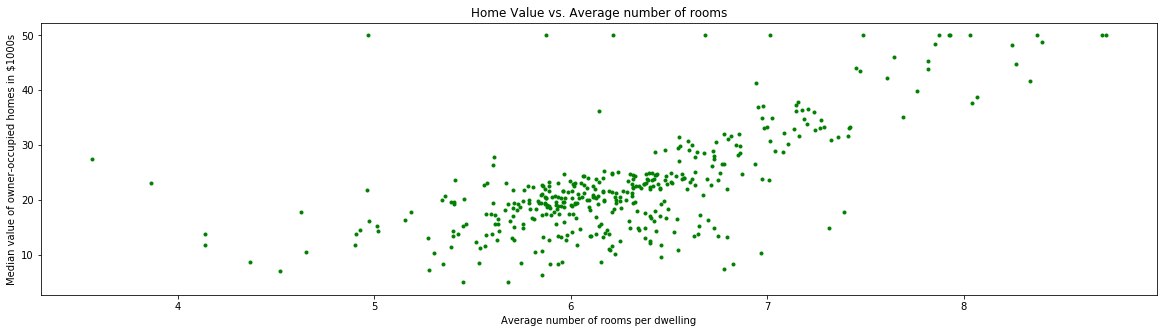

In [3]:
plt.figure(figsize=(20, 5))
col = 'LSTAT'

x = x_train
y = train_labels
plt.plot(x, y, '.', color= 'green')
plt.title('Home Value vs. Average number of rooms')
plt.xlabel('Average number of rooms per dwelling')
plt.ylabel('Median value of owner-occupied homes in $1000s')

In this plot, it is represented the **relationship between the home value in $1000's and the number of rooms**. As we can see, there is a clear correlation (positive) between both variables. However, **there is a lack of homocesdaticity**, since the variance between both variables is not constant 

## Techniques

### Common parameters

This is the definition of common paremeters to execute a benchmark that show different implementation of quantile regression.

The implemented methods are:
   * **OLS**: The estimation of quantiles using Ordinary Least Square. This technique will give us Confidence Intervals instead.
   * **Quantile Regresion**: The most common and simplest technique of quantile estimation in regression problems
   * **Random Forest**: Implementation with ensamble methods capable of learning non-linear patterns
   * **Gradient Boosting**: This technique is selected for being a common baseline in ML problems
   * **Deep Quantile Regression**: The aplication of quantile regression in Deep Learning architectures
        

In [4]:
METHODS = ['OLS', 'Quantile Regresion', 'Random forests', 'Gradient boosting', 'Deep Quantile Regression']

QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]

quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]

We use 5 quantiles to estimate uncertainty [0.1, 0.3, 0.5, 0.7, 0.9]. Other quantiles can be selected according to the business needs

In [5]:
preds = np.array([(method, q, x) 
                  for method in METHODS 
                  for q in QUANTILES
                  for x in x_test])
preds = pd.DataFrame(preds)
preds.columns = ['method', 'q', 'x']
preds = preds.apply(lambda x: pd.to_numeric(x, errors='ignore'))

In [6]:
preds['label'] = np.resize(test_labels, preds.shape[0])

#### OLS Linear regression

<a id='ols'>Implementation of confidence intervals using OLS </a>

The goal of implementing this technique also is to understand the difference between Confidence Intervals vs. Predictions Intervals
* Post with the Explanation: [Confidence intervals vs. Predictions Intervals](https://towardsdatascience.com/how-confidence-and-prediction-intervals-work-4592019576d8)

In [7]:
def ols_quantile(m, X, q):
    # m: OLS model.
    # X: X matrix.
    # q: Quantile.
    #
    # Set alpha based on q. Vectorized for different values of q.
    mean_pred = m.predict(X)
    se = np.sqrt(m.scale)
    return mean_pred + norm.ppf(q) * se

In [8]:
ols = sm.OLS(train_labels, X_train).fit()
preds.loc[preds.method == 'OLS', 'pred'] = np.concatenate(
    [ols_quantile(ols, X_test, q) for q in QUANTILES]) 

#### Quantile Regression

<a id='linear_quantile'>Quantile loss aplication in Linear Regression </a>

Estimate a quantile regression model using iterative reweighted least squares

Reference: https://www.statsmodels.org/devel/generated/statsmodels.regression.quantile_regression.QuantReg.html

In [9]:
quantreg = sm.QuantReg(train_labels, X_train) 
preds.loc[preds.method == 'Quantile Regresion', 'pred'] = np.concatenate(
    [quantreg.fit(q=q).predict(X_test) for q in QUANTILES]) 

#### Random forest

<a id='rf'>Quantile loss aplication in Random Forest </a>

This is the most common used technique in ML problems. 

Reference: https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html

In [10]:
N_ESTIMATORS = 1000
rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                                    min_samples_leaf=1, random_state=3, 
                                    verbose=True, 
                                    n_jobs=-1)  # Use maximum number of cores.
rf.fit(X_train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=3, verbose=True,
                      warm_start=False)

In [11]:
def rf_quantile(m, X, q):
    rf_preds = []
    for estimator in m.estimators_:
        rf_preds.append(estimator.predict(X))
    rf_preds = np.array(rf_preds).transpose()  # One row per record.
    return np.percentile(rf_preds, q * 100, axis=1)

In [12]:
preds.loc[preds.method == 'Random forests', 'pred'] = np.concatenate(
    [rf_quantile(rf, X_test, q) for q in QUANTILES]) 

#### Gradient Boosted trees

<a id='gradboost'>Quantile loss aplication in Gradient Boosted Trees </a>

In [13]:
def gb_quantile(X_train, train_labels, X, q):
    gbf = ensemble.GradientBoostingRegressor(loss='quantile', alpha=q,
                                             n_estimators=N_ESTIMATORS,
                                             max_depth=3,
                                             learning_rate=0.1, min_samples_leaf=9,
                                             min_samples_split=9)
    gbf.fit(X_train, train_labels)
    return gbf.predict(X)

In [14]:
preds.loc[preds.method == 'Gradient boosting', 'pred'] = np.concatenate(
    [gb_quantile(X_train, train_labels, X_test, q) for q in QUANTILES]) 

#### Deep Quantile Regression

<a id='dqr'>Quantile loss aplication Deep Quantile Regression</a>

Here, we implement the naive method of deep quantile regression. This method fits N Deep Quantile models, one for each quantile. 

In [15]:
EPOCHS = 200
BATCH_SIZE = 32
UNITS = 512

In [16]:
def tilted_loss(q, y, f):
    #e = (y - f)
    e = (f - y)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), axis=-1)

In [17]:
optimizer = tf.train.AdamOptimizer(0.001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [18]:
def keras_pred(x_train, train_labels, x_test, q):
    print(q)
    # Set input_dim for the number of features.
    if len(x_train.shape) == 1:
        input_dim = 1
    else:
        input_dim = x_train.shape[1]
    model = keras.Sequential([
      keras.layers.Dense(UNITS, activation=tf.nn.relu,
                         input_dim=input_dim),
      keras.layers.Dense(UNITS, activation=tf.nn.relu),
      keras.layers.Dense(1)
    ])
    
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer=optimizer)
    model.fit(x_train, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE,
              verbose=0, validation_split=0.2, callbacks=[early_stop])
    
    # Predict the quantile
    return model.predict(x_test)

In [19]:
preds.loc[preds.method == 'Deep Quantile Regression', 'pred'] = np.concatenate(
    [keras_pred(x_train_expanded, train_labels, x_test_expanded, q) 
     for q in QUANTILES]) 

0.1
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0.3
0.5
0.7
0.9


In [20]:
preds.head()

,method,q,x,label,pred
0,OLS,0.1,6.434,7.2,15.222074
1,OLS,0.1,5.913,18.8,10.614795
2,OLS,0.1,5.985,19.0,11.251502
3,OLS,0.1,6.250,27.0,13.594935
4,OLS,0.1,6.121,22.2,12.454169


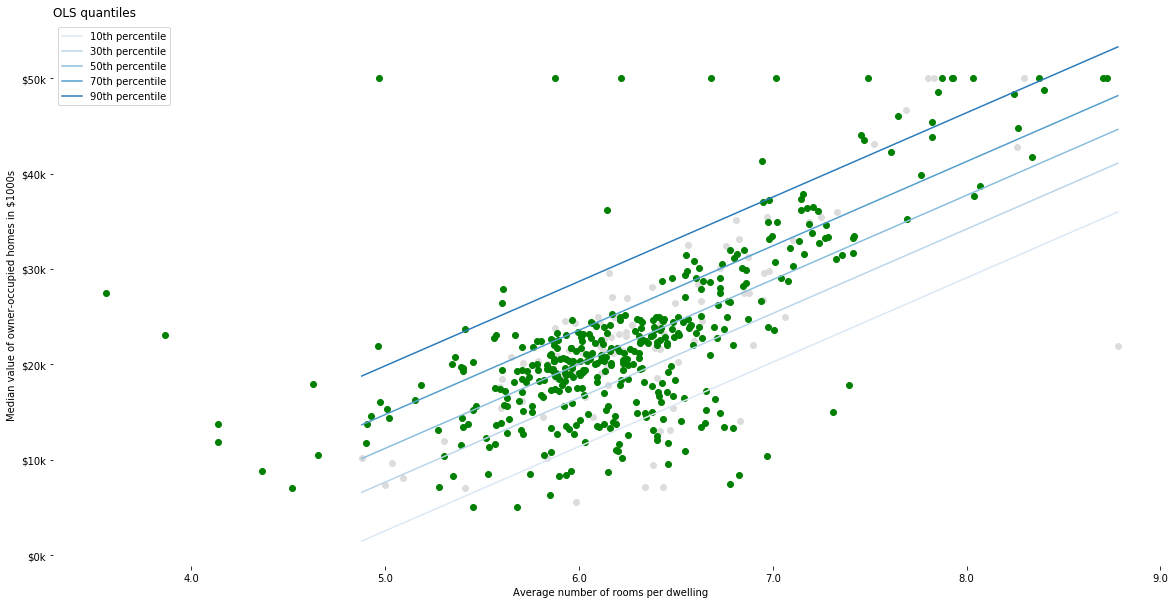

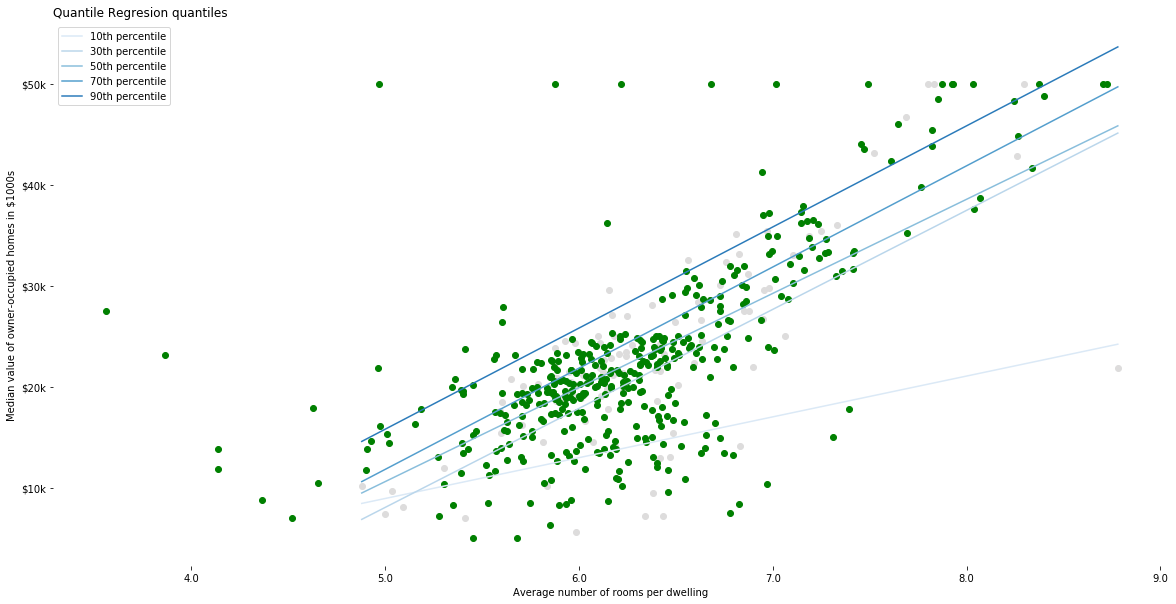

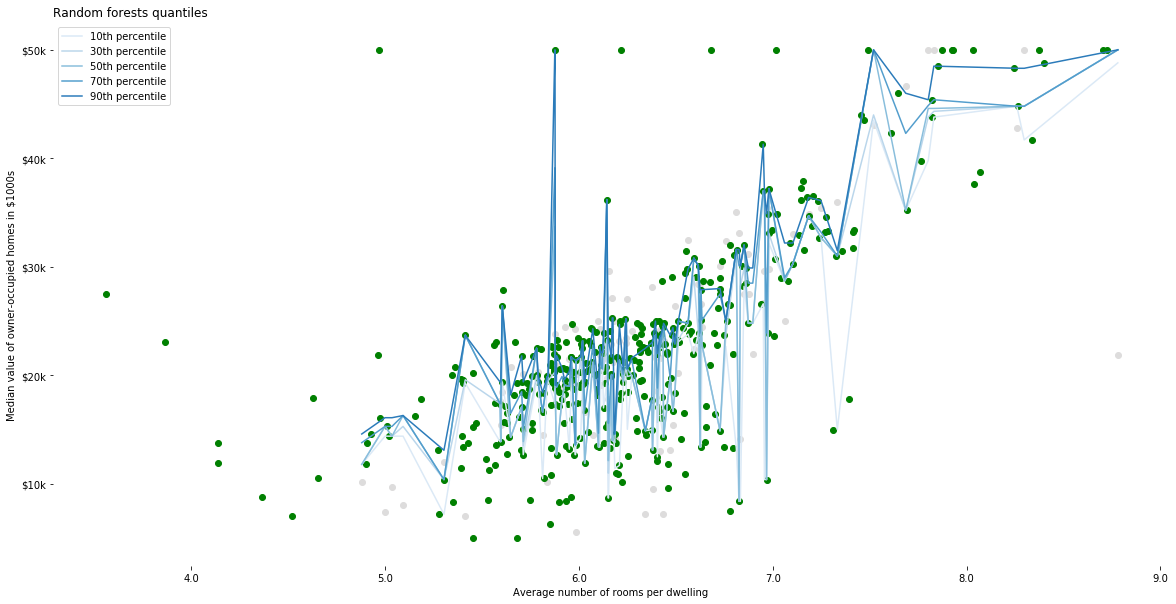

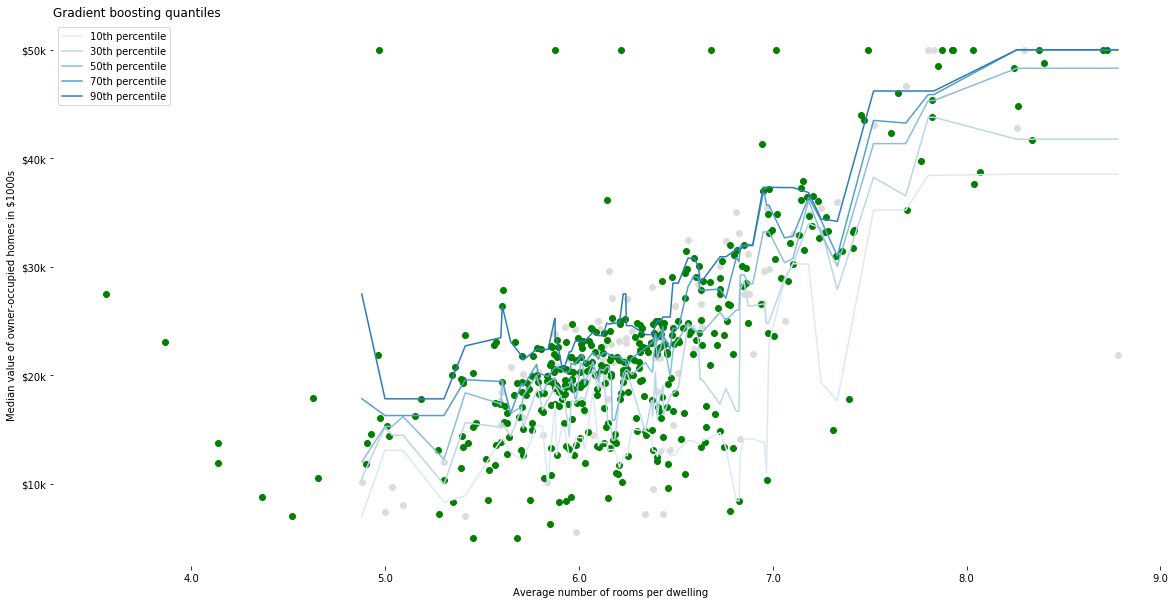

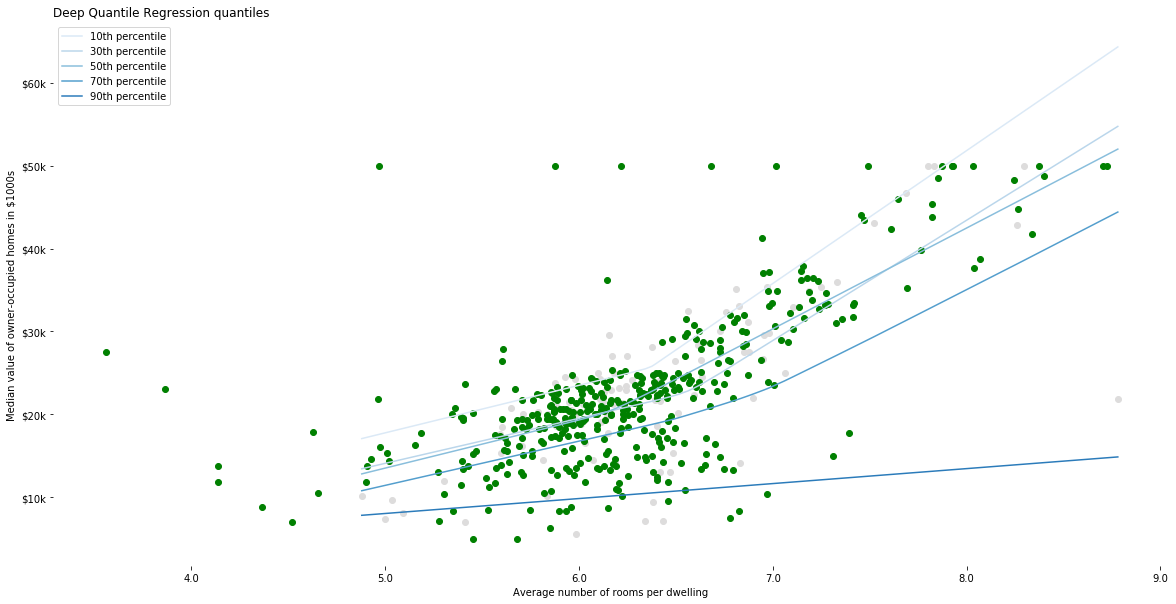

In [21]:
from matplotlib.ticker import FuncFormatter
from matplotlib.pyplot import figure
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

sns.set_palette(sns.color_palette('Blues'))
# Set dots to a light gray
dot_color = sns.color_palette('coolwarm', 3)[1]

for i, method in enumerate(METHODS):
    ax = plt.scatter(x_test, test_labels, color=dot_color)
    plt.scatter(x_train, train_labels, color= 'green')
    plt.plot(preds[preds.method == method].pivot_table(
        index='x', columns='q', values='pred'))

    
    ax.axes.xaxis.set_major_formatter(FuncFormatter(
        lambda x, _: '{:}'.format(x)))
    ax.axes.yaxis.set_major_formatter(FuncFormatter(
        lambda y, _: '${:.0f}k'.format(y)))
    plt.xlabel('Average number of rooms per dwelling')
    plt.ylabel('Median value of owner-occupied homes in $1000s')
    plt.title(method + ' quantiles', loc='left')
    sns.despine(left=True, bottom=True)
    plt.legend(quantiles_legend)
    plt.show()

In this plot we can observe the quantile estimation with the different proposed techniques. These techniques present different behaviors, the more relevant insights found from the prediction results of each of them are: 


**Insights**:

* OSL divides the P(Y|X) distribution in parts/quantile and estimate de conditional mean of each quantile

* Ensamble methods such as Random Forest and Gradient Boosting are more affected by outliers. These methods give a very good performance in the testing set but they are more sucespectible to learn from noise.  

* Deep quantile regression methods present a similar behavior to quantile regression but as we can see in the last plot it is possible to estimate non-linear patterns. However this flexibility produce the third and fourth quantile crossing in X~0.75. This might cause a performance degradation and interpretability problems. 

In [22]:
preds.to_csv('benchmark_quantile.csv', index=False)

### Conclusions

Goals achieved in this notebook:

* The implementation of the most common techniques used for quantile estimation. The implementation of each technique and libraries used could be taken as a reference.
* Understand the behavior and limitation of each of them using a the toy dataset included in scikit-learn

### Future Work

* For further investigation on the limitations of each of them it might be necessary to apply them to a **real dataset**. The dataset used here in simplified and normalized to ease the usage for the data science community

* Continue with the validation of Deep Quantile Regression techniques and the **quantile crossing problem**. We choose to continue with this technique because it is considered a baseline for **estimating forecasting uncertainty**